In [17]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive')
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mounted at /content/drive
/bin/bash: line 1: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [18]:
pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.

In [19]:
import warnings
warnings.filterwarnings("ignore")
import os,sys
from pytorch_forecasting.data.encoders import TorchNormalizer
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
from pytorch_forecasting import NegativeBinomialDistributionLoss, DeepAR
import torch
from pytorch_forecasting.data.encoders import TorchNormalizer
import os,sys
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from scipy.signal import find_peaks
import operator
import statsmodels.api as sm
from itertools import combinations
import pickle

In [20]:
zone_demand = pd.read_csv('combined_demand_df_1h.csv')
zone_demand

,time_slot,4,12,13,24,41,42,43,45,48,...,237,238,239,243,244,246,249,261,262,263
0,2021-01-01 00:00:00,3.0,0.0,3.0,7.0,5.0,2.0,22.0,4.0,81.0,...,35.0,39.0,28.0,0.0,2.0,9.0,20.0,2.0,15.0,54.0
1,2021-01-01 01:00:00,1.0,0.0,2.0,4.0,22.0,14.0,6.0,0.0,72.0,...,16.0,27.0,44.0,1.0,3.0,12.0,32.0,6.0,18.0,49.0
2,2021-01-01 02:00:00,2.0,0.0,2.0,2.0,11.0,9.0,5.0,0.0,63.0,...,17.0,23.0,21.0,0.0,3.0,13.0,17.0,5.0,7.0,27.0
3,2021-01-01 03:00:00,3.0,0.0,0.0,2.0,3.0,7.0,2.0,1.0,31.0,...,7.0,10.0,8.0,0.0,1.0,3.0,10.0,1.0,2.0,12.0
4,2021-01-01 04:00:00,0.0,0.0,0.0,2.0,8.0,4.0,0.0,0.0,20.0,...,2.0,4.0,6.0,0.0,2.0,4.0,3.0,2.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24808,2023-10-31 19:00:00,2.0,0.0,37.0,6.0,27.0,4.0,51.0,12.0,140.0,...,339.0,179.0,199.0,1.0,0.0,105.0,147.0,23.0,80.0,126.0
24809,2023-10-31 20:00:00,5.0,0.0,37.0,10.0,12.0,1.0,88.0,7.0,128.0,...,394.0,119.0,191.0,1.0,1.0,93.0,159.0,26.0,67.0,112.0
24810,2023-10-31 21:00:00,3.0,0.0,27.0,10.0,4.0,4.0,49.0,7.0,161.0,...,281.0,76.0,176.0,0.0,0.0,88.0,184.0,16.0,35.0,99.0
24811,2023-10-31 22:00:00,9.0,0.0,14.0,9.0,12.0,4.0,37.0,11.0,175.0,...,183.0,36.0,94.0,0.0,0.0,53.0,190.0,12.0,21.0,60.0


In [33]:
def remove_similar_elements(lst, threshold, index=0):
    if index >= len(lst) - 1:
        return lst

    current_element = lst[index]
    new_list = [current_element]

    for i in range(index + 1, len(lst)):
        if abs(current_element - lst[i]) > threshold:
            new_list.append(lst[i])

    lst[index + 1:] = remove_similar_elements(new_list[1:], threshold)
    return remove_similar_elements(lst, threshold, index + 1)

# Example usage:
input_list = [  1, 167, 166, 142, 143, 168, 3,  22, 141, 165]
threshold_value = 2
result = remove_similar_elements(input_list, threshold_value)
print(result)



[1, 167, 142, 22]


In [37]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

zone_significant_lags = {}

# Assuming zone_demand and chosen_cluster_centers are defined
for c in zone_demand.columns[1:]:
    fig, ax = plt.subplots(figsize=(25, 5))

    # Plot the PACF
    plot_pacf(zone_demand[c], lags=169, ax=ax)

    # Highlight significant lags
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=2)
    ax.axhline(y=-1.96/np.sqrt(len(zone_demand[c])), color='red', linestyle='--', linewidth=2)
    ax.axhline(y=1.96/np.sqrt(len(zone_demand[c])), color='red', linestyle='--', linewidth=2)

    plt.title(f'Partial Autocorrelation Function (PACF) for {c}')
    plt.show()

    # Compute PACF values
    pacf_values = pacf(zone_demand[c], nlags=169)

    # Extract significant lags
    top_n_lags = 11  # Adjust the number as needed
    sorted_lags = np.argsort(-np.abs(pacf_values))
    # exclude 0 (itself)
    significant_lags = sorted_lags[1:top_n_lags]

    significant_lags = significant_lags.tolist()

    # Create a copy of the list before passing it to the function
    result = remove_similar_elements(significant_lags, threshold=2, index=0)

    zone_significant_lags[c] = result

    # Print significant lags
    print(f'Significant Lags for {c}: {significant_lags}')

Output hidden; open in https://colab.research.google.com to view.

In [38]:
print(zone_significant_lags)

{'4': [1, 167, 142, 22], '12': [1, 21, 24, 4], '13': [1, 23, 17, 5, 143, 167], '24': [1, 23, 168, 143, 20], '41': [1, 23, 168, 144, 20], '42': [1, 23, 168, 144], '43': [1, 4, 25, 21, 7], '45': [1, 23, 167, 19], '48': [1, 25, 22, 18, 167, 143], '50': [1, 23, 19, 167, 143], '68': [1, 19, 23, 4], '74': [1, 23, 168, 20, 143], '75': [1, 5, 23, 14, 20, 26], '79': [1, 142, 166, 25, 169, 21], '87': [1, 18, 23, 5, 167], '88': [1, 5, 23, 18], '90': [1, 19, 25, 22, 4], '100': [1, 23, 167, 143, 20], '107': [1, 25, 19, 22, 167], '113': [1, 18, 4, 23], '114': [1, 167, 22, 142, 25], '116': [1, 23, 168, 144, 48], '120': [1, 82, 78, 98, 116, 145, 4, 9, 140, 166], '125': [1, 23, 19, 143, 167], '127': [1, 24, 168, 144], '128': [24, 2, 144, 72, 96, 92, 48, 117], '137': [1, 23, 5, 26, 19, 167], '140': [1, 25, 22, 8, 145], '141': [1, 23, 19, 5], '142': [1, 23, 19, 5, 168], '143': [1, 23, 5, 167, 19], '144': [1, 23, 20, 167, 142], '148': [1, 166, 141, 21, 169], '151': [1, 23, 5, 168, 11], '152': [1, 23, 168,

In [39]:
shortest_length = 100
for v in zone_significant_lags.values():
  if len(v) < shortest_length:
    shortest_length = len(v)

print(shortest_length)

4


In [42]:
### filter zone_significant_lags so that each zone has top 4 significant lags only
new_zone_significant_lags = {}
for k, v in zone_significant_lags.items():
  new_zone_significant_lags[k] = v[:shortest_length]

print(new_zone_significant_lags)

{'4': [1, 167, 142, 22], '12': [1, 21, 24, 4], '13': [1, 23, 17, 5], '24': [1, 23, 168, 143], '41': [1, 23, 168, 144], '42': [1, 23, 168, 144], '43': [1, 4, 25, 21], '45': [1, 23, 167, 19], '48': [1, 25, 22, 18], '50': [1, 23, 19, 167], '68': [1, 19, 23, 4], '74': [1, 23, 168, 20], '75': [1, 5, 23, 14], '79': [1, 142, 166, 25], '87': [1, 18, 23, 5], '88': [1, 5, 23, 18], '90': [1, 19, 25, 22], '100': [1, 23, 167, 143], '107': [1, 25, 19, 22], '113': [1, 18, 4, 23], '114': [1, 167, 22, 142], '116': [1, 23, 168, 144], '120': [1, 82, 78, 98], '125': [1, 23, 19, 143], '127': [1, 24, 168, 144], '128': [24, 2, 144, 72], '137': [1, 23, 5, 26], '140': [1, 25, 22, 8], '141': [1, 23, 19, 5], '142': [1, 23, 19, 5], '143': [1, 23, 5, 167], '144': [1, 23, 20, 167], '148': [1, 166, 141, 21], '151': [1, 23, 5, 168], '152': [1, 23, 168, 144], '153': [168, 23, 2, 26], '158': [1, 167, 22, 142], '161': [1, 25, 4, 169], '162': [1, 25, 22, 17], '163': [1, 5, 25, 19], '164': [1, 18, 5, 23], '166': [1, 23, 5

In [43]:
## create dataframe for clustering

df = pd.DataFrame(new_zone_significant_lags)
df

,4,12,13,24,41,42,43,45,48,50,...,237,238,239,243,244,246,249,261,262,263
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,167,21,23,23,23,23,4,23,25,23,...,25,23,4,24,24,25,25,4,23,23
2,142,24,17,168,168,168,25,167,22,19,...,4,4,23,21,16,22,21,20,20,19
3,22,4,5,143,144,144,21,19,18,167,...,17,20,19,168,168,19,142,23,167,167


In [44]:
transposed_df_t = df.T
transposed_df_t

,0,1,2,3
4,1,167,142,22
12,1,21,24,4
13,1,23,17,5
24,1,23,168,143
41,1,23,168,144
...,...,...,...,...
246,1,25,22,19
249,1,25,21,142
261,1,4,20,23
262,1,23,20,167


In [45]:
print(transposed_df_t.columns)

RangeIndex(start=0, stop=4, step=1)


In [46]:
new_column_names = {0: 'Rank 0 Lag', 1: 'Rank 1 Lag', 2: 'Rank 2 Lag', 3: 'Rank 3 Lag', 4: 'Rank 4 Lag', 5: 'Rank 5 Lag', 6: 'Rank 6 Lag', 7: 'Rank 7 Lag', 8: 'Rank 8 Lag', 9: 'Rank 9 Lag'}
transposed_df_t.rename(columns=new_column_names, inplace=True)

In [47]:
transposed_df_t

,Rank 0 Lag,Rank 1 Lag,Rank 2 Lag,Rank 3 Lag
4,1,167,142,22
12,1,21,24,4
13,1,23,17,5
24,1,23,168,143
41,1,23,168,144
...,...,...,...,...
246,1,25,22,19
249,1,25,21,142
261,1,4,20,23
262,1,23,20,167


In [48]:
transposed_df_t.to_csv("zone_significant_lags_after_pruning.csv")

# Spectral Clustering (n=6)

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

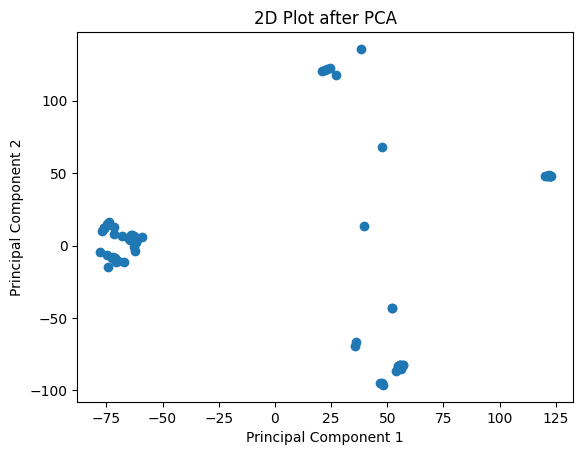

In [50]:
# Step 2: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca = pca.fit_transform(transposed_df_t)

# Step 3: Create a new DataFrame with the reduced dimensions
df_reduced = pd.DataFrame(data=df_pca, columns=['Principal Component 1', 'Principal Component 2'], index=transposed_df_t.index)

# Step 4: Plot the data on a 2D plot
plt.scatter(df_reduced['Principal Component 1'], df_reduced['Principal Component 2'])
plt.title('2D Plot after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [51]:
# Apply spectral clustering
from sklearn.cluster import SpectralClustering

n_clusters = 6  # You can adjust the number of clusters based on your data
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
df_reduced['cluster'] = spectral_clustering.fit_predict(transposed_df_t)

In [52]:
# Step 6: Evaluate the clustering using silhouette score or other metrics
silhouette_avg = silhouette_score(transposed_df_t, df_reduced['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5137688009917185


In [53]:
df_reduced

,Principal Component 1,Principal Component 2,cluster
4,24.630010,122.590666,1
12,-74.009776,16.156179,4
13,-77.040409,10.351545,4
24,121.826519,48.494477,2
41,122.633883,47.904991,2
...,...,...,...
246,-62.625584,6.379647,4
249,36.101114,-66.918393,5
261,-62.822460,-0.965189,3
262,55.490081,-82.771077,5


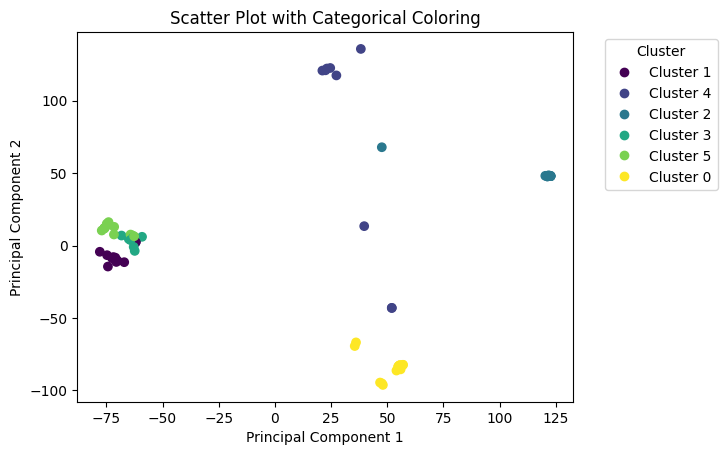

In [54]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df_reduced with 'Principal Component 1', 'Principal Component 2', and 'cluster' columns

# Scatter plot using Matplotlib
scatter = plt.scatter(df_reduced['Principal Component 1'], df_reduced['Principal Component 2'], c=df_reduced['cluster'].astype('category').cat.codes, cmap='viridis')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot with Categorical Coloring')

# Add legend outside the plot to the right
legend_labels = df_reduced['cluster'].unique()
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {label}' for label in legend_labels], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [55]:
# Step 7: Explore the clustered zones
# You can analyze and visualize the clusters as needed
clustered_zones = df_reduced.groupby('cluster').apply(lambda x: x.index.tolist())
print("Clustered Zones:")
for i, zones in enumerate(clustered_zones):
    print(f"Cluster {i}: {zones}")

Clustered Zones:
Cluster 0: ['107', '113', '137', '153', '164', '166', '170', '194', '236', '237', '238']
Cluster 1: ['4', '45', '74', '79', '114', '120', '148', '158', '202']
Cluster 2: ['24', '41', '42', '100', '116', '127', '128', '152', '211', '232']
Cluster 3: ['43', '75', '88', '90', '163', '234', '239', '261']
Cluster 4: ['12', '13', '48', '68', '87', '140', '141', '142', '162', '229', '231', '233', '246']
Cluster 5: ['50', '125', '143', '144', '151', '161', '186', '209', '224', '230', '243', '244', '249', '262', '263']


# Spectral Clustering (n=10)

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

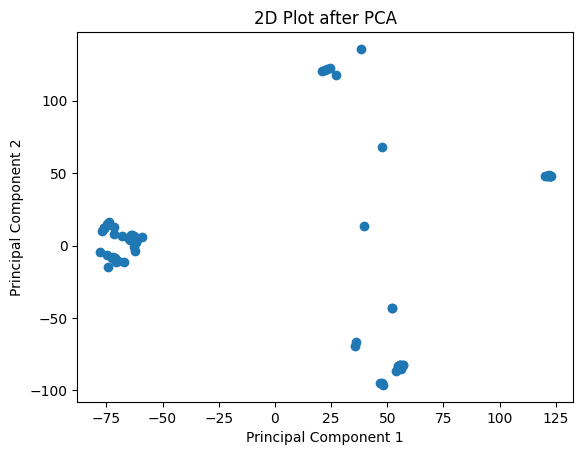

In [57]:
# Step 2: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca = pca.fit_transform(transposed_df_t)

# Step 3: Create a new DataFrame with the reduced dimensions
df_reduced = pd.DataFrame(data=df_pca, columns=['Principal Component 1', 'Principal Component 2'], index=transposed_df_t.index)

# Step 4: Plot the data on a 2D plot
plt.scatter(df_reduced['Principal Component 1'], df_reduced['Principal Component 2'])
plt.title('2D Plot after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [58]:
# Apply spectral clustering
from sklearn.cluster import SpectralClustering

n_clusters = 10  # You can adjust the number of clusters based on your data
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
df_reduced['cluster'] = spectral_clustering.fit_predict(transposed_df_t)
transposed_df_t['cluster'] = df_reduced['cluster']

In [59]:
# Step 6: Evaluate the clustering using silhouette score or other metrics
silhouette_avg = silhouette_score(transposed_df_t, df_reduced['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5581212152866192


In [60]:
df_reduced

,Principal Component 1,Principal Component 2,cluster
4,24.630010,122.590666,2
12,-74.009776,16.156179,4
13,-77.040409,10.351545,4
24,121.826519,48.494477,3
41,122.633883,47.904991,3
...,...,...,...
246,-62.625584,6.379647,6
249,36.101114,-66.918393,9
261,-62.822460,-0.965189,7
262,55.490081,-82.771077,1


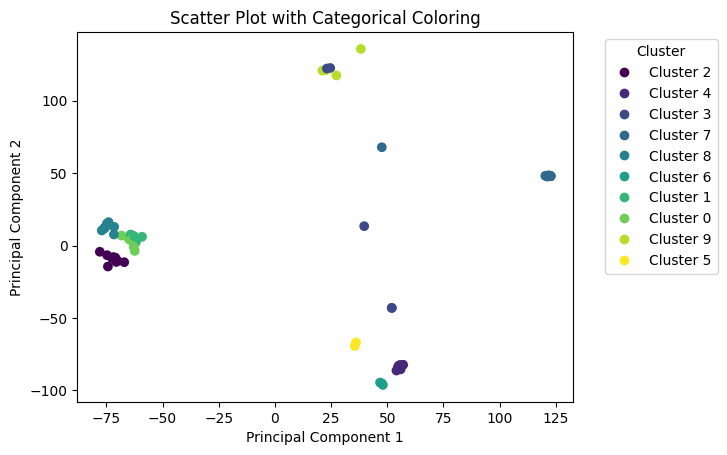

In [61]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df_reduced with 'Principal Component 1', 'Principal Component 2', and 'cluster' columns

# Scatter plot using Matplotlib
scatter = plt.scatter(df_reduced['Principal Component 1'], df_reduced['Principal Component 2'], c=df_reduced['cluster'].astype('category').cat.codes, cmap='viridis')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot with Categorical Coloring')

# Add legend outside the plot to the right
legend_labels = df_reduced['cluster'].unique()
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {label}' for label in legend_labels], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [62]:
# Step 7: Explore the clustered zones
# You can analyze and visualize the clusters as needed
clustered_zones = df_reduced.groupby('cluster').apply(lambda x: x.index.tolist())
print("Clustered Zones:")
for i, zones in enumerate(clustered_zones):
    print(f"Cluster {i}: {zones}")

Clustered Zones:
Cluster 0: ['113', '137', '153', '164', '166', '194', '236', '237', '238']
Cluster 1: ['50', '144', '186', '209', '224', '230', '243', '244', '262', '263']
Cluster 2: ['4', '114', '120', '148', '158']
Cluster 3: ['24', '41', '42', '100', '116', '127', '128', '152', '211', '232']
Cluster 4: ['12', '13', '68', '87', '140', '141', '142', '229', '231', '233']
Cluster 5: ['143', '151', '161']
Cluster 6: ['48', '90', '107', '162', '170', '246']
Cluster 7: ['43', '75', '88', '163', '234', '239', '261']
Cluster 8: ['45', '74', '79', '202']
Cluster 9: ['125', '249']


In [63]:
# Assuming statistical_features_df has 'cluster' column indicating the cluster for each zone
# Assuming kmeans is the trained KMeans model

# Step 8: Find the zone closest to the cluster center for each cluster
closest_zones = []

# Iterate through each cluster
for i in range(n_clusters):
    cluster_zones = transposed_df_t[transposed_df_t['cluster'] == i].index

    # Calculate the mean of each feature for the cluster
    cluster_center = transposed_df_t.loc[cluster_zones, transposed_df_t.columns != 'cluster'].mean()

    # Calculate distance between each zone in the cluster and the cluster center
    distances = np.linalg.norm(transposed_df_t.loc[cluster_zones, transposed_df_t.columns != 'cluster'] - cluster_center, axis=1)

    # Find the zone with the minimum distance (closest to the cluster center)
    closest_zone = cluster_zones[np.argmin(distances)]
    closest_zones.append(closest_zone)

# Display the result
for i, closest_zone in enumerate(closest_zones):
    print(f"Cluster {i} - Closest Zone: {closest_zone}")

Cluster 0 - Closest Zone: 238
Cluster 1 - Closest Zone: 50
Cluster 2 - Closest Zone: 120
Cluster 3 - Closest Zone: 232
Cluster 4 - Closest Zone: 141
Cluster 5 - Closest Zone: 151
Cluster 6 - Closest Zone: 246
Cluster 7 - Closest Zone: 239
Cluster 8 - Closest Zone: 74
Cluster 9 - Closest Zone: 125


In [64]:
closest_zones

['238', '50', '120', '232', '141', '151', '246', '239', '74', '125']